# Analysis of single-cell RNA-seq data for Mouse Retinal Development


This Python notebook performs an analysis of the cell types and their marker genes on provided GSE118614_Smart dataset.

# Analysis of 10X data


In [1]:
import numpy as np
import pandas as pd
# from pandas.core import frame
import scanpy as sc
# import matplotlib.pyplot as plt
# from sklearn.neighbors import NearestNeighbors
# from sklearn.neighbors import DistanceMetric
# from sklearn.decoHeylsition import PCA
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
import re
import collections
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

In [2]:
def cmake_unique(icat):
    ocat=icat.copy()
    ocat=list(ocat)
    for ii in range(len(ocat)):
        for jj in range(ii+1,len(ocat)):
            if ocat[ii]==ocat[jj]:
                ocat[jj]=ocat[jj]+'0'
    return ocat

## Quality control
First read in the data

The count matrix is provided in .mtx format and can be downloaded here: [10x_mouse_retina_development.mtx](https://www.dropbox.com/s/6d76z4grcnaxgcg/10x_mouse_retina_development.mtx?dl=0)

matrix.mtx - The count matrix containing raw counts for barcodes. Rows correspond to cells and columns to genes

genes.tsv - contains the ensembl IDs labelling the genes in each column of the counts matrix

barcodes.tsv - contains the cell barcodes labelling the cells in each row of the counts matrix

10x_Mouse_retina_pData_umap2_CellType_annot_w_horiz.csv - Cellular Phenotype Data

In [3]:
sc.settings.verbosity = 3            
sc.settings.set_figure_params(dpi=80, facecolor='white')

this file that will store the analysis results

In [4]:
results_file = 'swrite10x/retsmart.h5ad'  


Reading the data

In [5]:
adata = sc.read_10x_mtx(
    'sdata10x',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading
cells = pd.read_csv('sdata10x/10x_Mouse_retina_pData_umap2_CellType_annot_w_horiz.csv')
adata.obs['CellType']=cells['umap2_CellType'].values
adata.obs['oCellType']=cells['old_CellType_annot'].values

adata.obs['Age']=cells['age'].values
adata.obs['Plate']=cells['sample'].values
adata=adata[adata.obs.CellType.str.startswith('Early'), :]



... reading from cache file cache\sdata10x-matrix.h5ad


Extracting E14, E18, and P2 data

In [6]:
adata_All=adata.copy()

adata=adata[(adata.obs['Age']=='E14') | (adata.obs['Age']=='E18') | (adata.obs['Age']=='P2'),:]

adata.var_names_make_unique()

adata.obs_names_make_unique()

nCells = adata.X.shape[0]
nGenes = adata.X.shape[1]
print('Data has', nGenes, 'genes in', nCells, 'cells')

Data has 27998 genes in 15224 cells


To identify potential doublets in the data each cell can be scored using the method of Wollock et al. 2018. Here we haven't performed this analysis.

 Let’s assemble some information about mitochondrial genes, ribosormal genes, and hemoglobin genes, which are important for quality control. Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017): High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016),  possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane. 


In [7]:
# Calculate mitochondrial gene content
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['ribo'] = adata.var_names.str.startswith(("Rps","Rpl"))
adata.var['hb'] = adata.var_names.str.startswith(("Hba","Hbb","Hbq"))

sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)

A violin and scatter plot of some of the computed quality measures: the number of genes expressed in the count matrix, the total counts per cell, the percentage of counts in mitochondrial genes. n_genes_by_counts is the number of unique genes expressed in each cells, and total_counts is the total number of genes expressed in each cell.

C:\ProgramData\Anaconda3\envs\retisep\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'CellType' as categorical
C:\ProgramData\Anaconda3\envs\retisep\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'oCellType' as categorical
C:\ProgramData\Anaconda3\envs\retisep\lib\site-packages\anndata\_core\anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version.

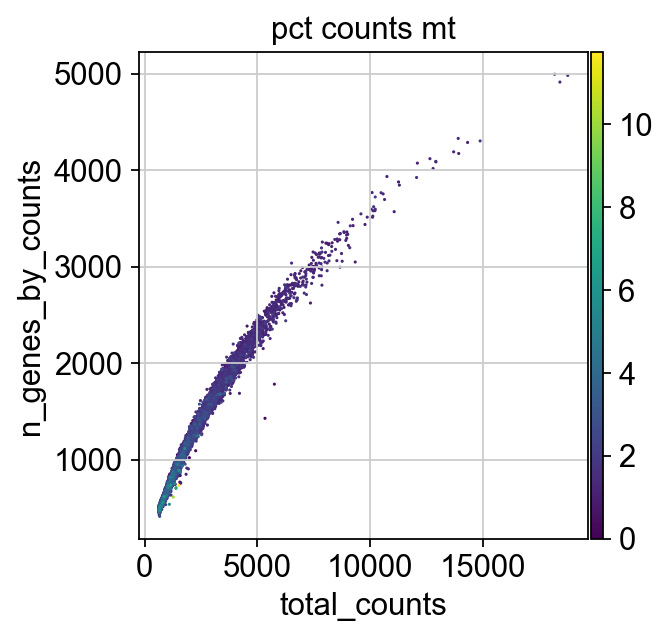

In [8]:
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts', color='pct_counts_mt')


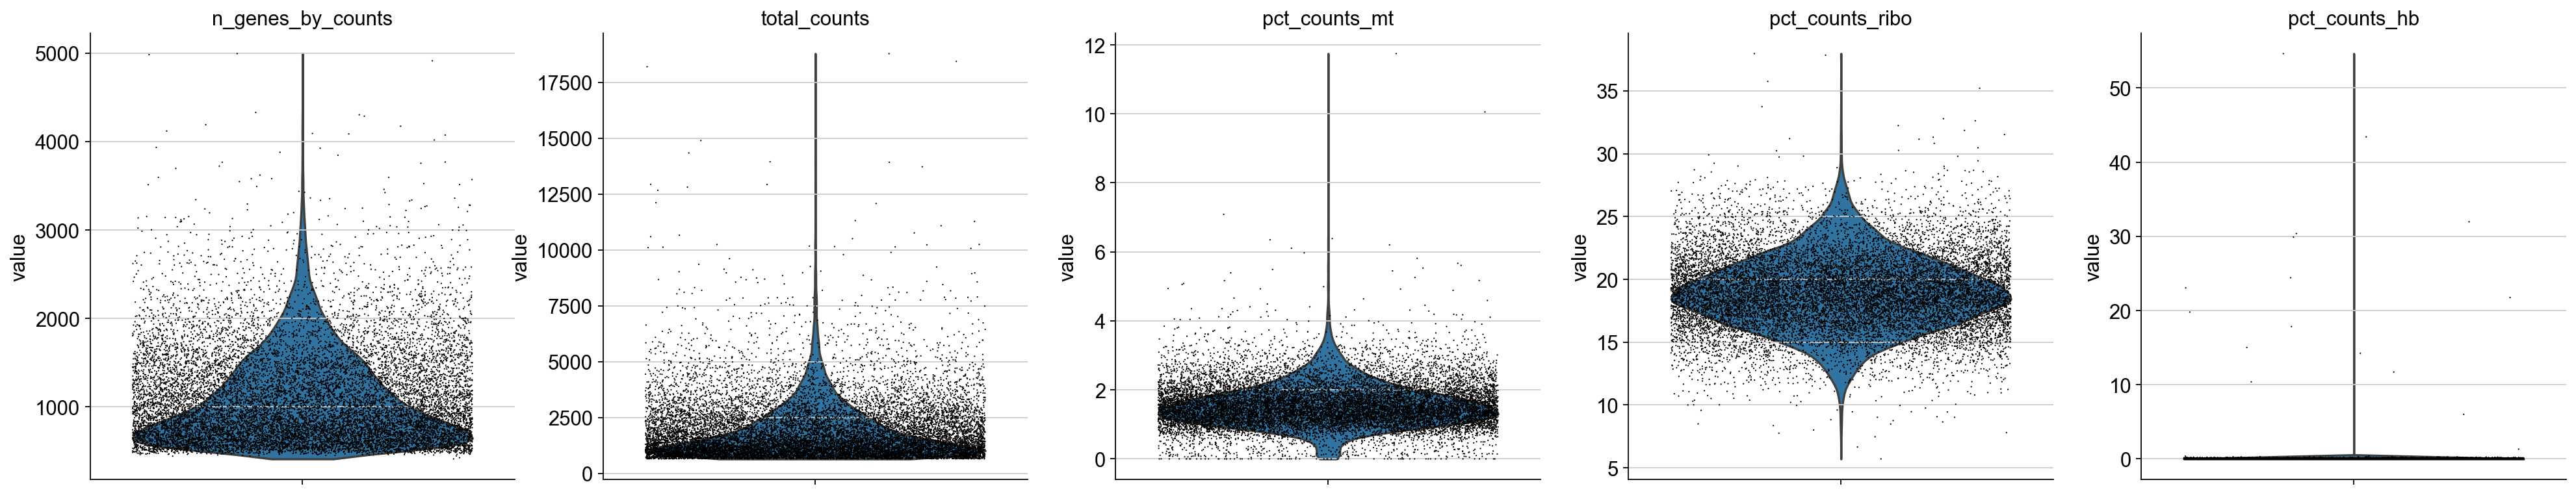

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt' , 'pct_counts_ribo', 'pct_counts_hb'],
             jitter=0.4, multi_panel=True)

These analysis indicate that  we can filter out cells with more that 3000 genes by count. It seems also typical to filter out cells with more that 5% of mitocondrial genes expressed. The scatter plot approves that the cells with more than 5% mt genes expressed have less total counts that other cells. 

We perform some additional basic quality control filtering to remove genes/cells based on the following criteria:

Remove genes expressed in fewer than 3 cells
Remove cells with more than 5% mitochondrial reads
Remove cells with outlying number of UMI counts per cell (outside the range of mean  ±  3  ×  standard deviation)
Remove cells expressing fewer than 200 genes

In [10]:
adata.obs['total_counts_log'] = np.log10(adata.obs['total_counts'])


 Calculate mean and standard deviation for filtering


In [11]:
sd_counts = np.std(adata.obs['total_counts_log'])
mean_counts = np.mean(adata.obs['total_counts_log'])

Filter cells with counts outside mean ± 3s.d.


In [12]:

max_counts_filter = mean_counts + 3*sd_counts
min_counts_filter = mean_counts - 3*sd_counts
counts_filter = np.logical_and(adata.obs['total_counts_log'] >= min_counts_filter,
                               adata.obs['total_counts_log'] <= max_counts_filter)
robomt_filter = np.logical_or(adata.obs['pct_counts_mt'] >= 5,
                               adata.obs['pct_counts_ribo'] <= 5)
robomthb_filter = np.logical_or(robomt_filter,adata.obs['pct_counts_hb'] >= 5)
robomthb_filter_keep= np.invert(robomthb_filter)                               

print('%d cells with extreme counts filtered' % (adata.X.shape[0] - np.sum(counts_filter)))
print("filtered %d cells with more than 5 percent mitochondrial reads" %(sum(adata.obs['pct_counts_mt'] >= 5)))
print("filtered %d cells with less than 5 percent ribosormal reads" %(sum(adata.obs['pct_counts_ribo'] <= 5)))
print("filtered %d cells with more than 5 percent hemoglobin reads" %(sum(adata.obs['pct_counts_hb'] >= 5)))

adata = adata[np.logical_and(robomthb_filter_keep, counts_filter), :]
nCells = adata.X.shape[0]
nGenes = adata.X.shape[1]
print('Data has', nGenes, 'genes in', nCells, 'cells')


adata = adata[adata.obs['n_genes_by_counts'] < 3000, :]

sc.pp.filter_cells(adata, min_genes=200)
nCells = adata.X.shape[0]
nGenes = adata.X.shape[1]
print('Data has', nGenes, 'genes in', nCells, 'cells')

sc.pp.filter_genes(adata, min_cells=3)



Trying to set attribute `.obs` of view, copying.


46 cells with extreme counts filtered
filtered 20 cells with more than 5 percent mitochondrial reads
filtered 0 cells with less than 5 percent ribosormal reads
filtered 15 cells with more than 5 percent hemoglobin reads
Data has 27998 genes in 15144 cells
Data has 27998 genes in 15093 cells
filtered out 12404 genes that are detected in less than 3 cells


 See how many cells and genes left after filtering


In [13]:
nCells = adata.X.shape[0]
nGenes = adata.X.shape[1]
print('Data has', nGenes, 'genes in', nCells, 'cells')

Data has 15594 genes in 15093 cells


Identify highest expressed genes to filter genes which are highly expressed in all cells.

normalizing counts per cell
    finished (0:00:00)


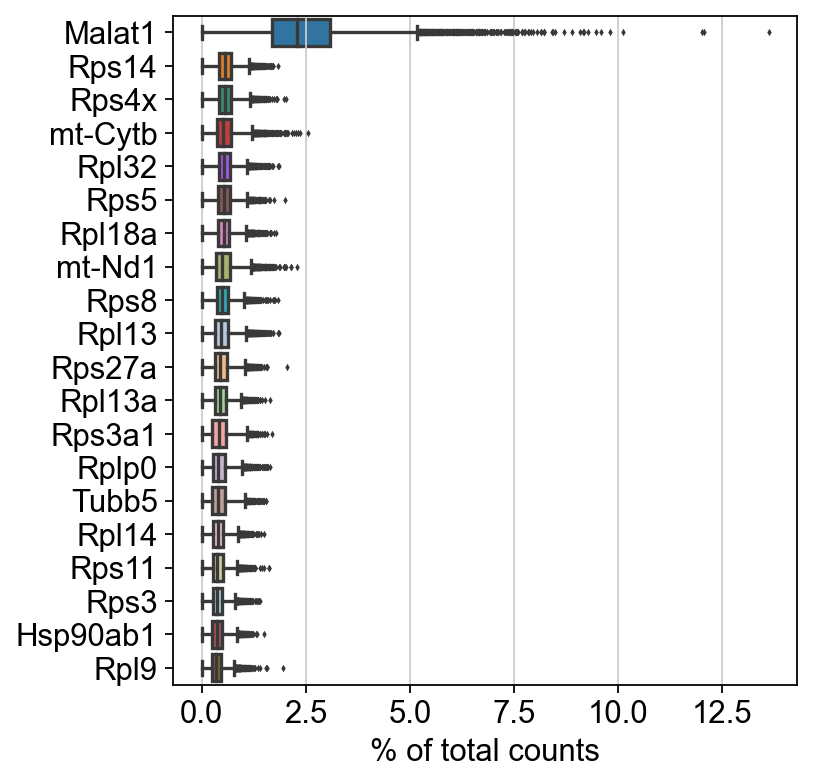

Trying to set attribute `.obs` of view, copying.


In [14]:
sc.pl.highest_expr_genes(adata, n_top=20)


malat1_gene = adata.var_names.str.startswith('Malat1')


mito_genes = adata.var_names.str.startswith('mt-')
hb_genes = adata.var_names.str.startswith(("Hba","Hbb","Hbq"))
ribo_gene= adata.var_names.str.startswith(("Rps","Rpl"))

remove = np.add(mito_genes, malat1_gene)
remove = np.add(remove, hb_genes)
remove = np.add(remove, ribo_gene)

keep = np.invert(remove)

adata = adata[:,keep]
sc.pp.filter_cells(adata, min_genes=1)



After removig Malat1 gene,

normalizing counts per cell
    finished (0:00:00)


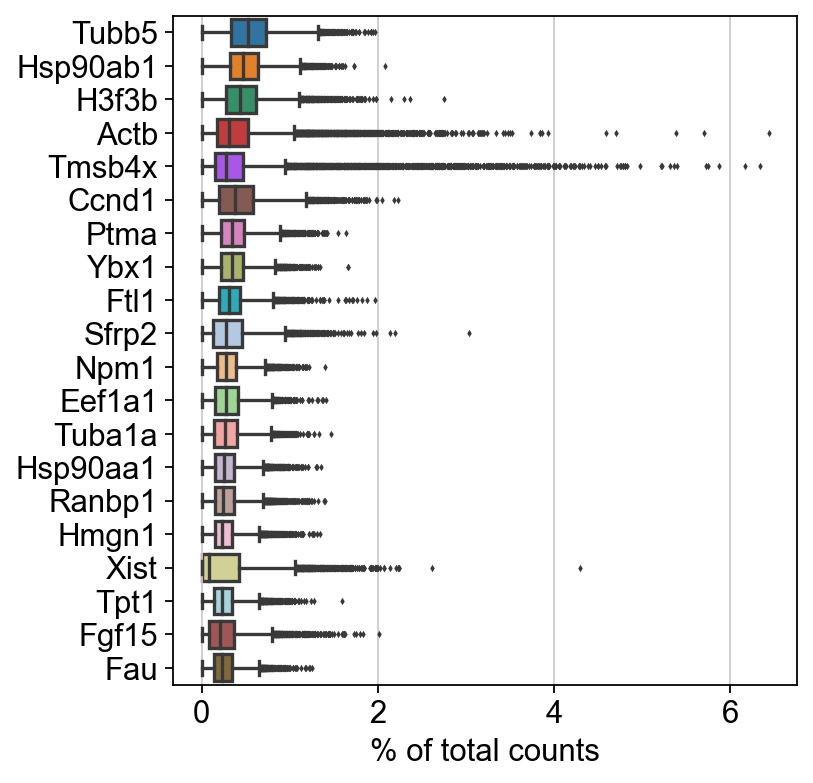

Data has 15469 genes in 15093 cells


In [15]:
sc.pl.highest_expr_genes(adata, n_top=20)

# See how many cells and genes left after filtering
nCells = adata.X.shape[0]
nGenes = adata.X.shape[1]
print('Data has', nGenes, 'genes in', nCells, 'cells')

Calculate QC metrics again after filtering,

In [16]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt','ribo','hb'], percent_top=None, log1p=False, inplace=True)


## Normalisation and Logarithmize


In [17]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

# Logarithmize the data:
sc.pp.log1p(adata) # log(X+1)
adata.raw = adata


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


## Identifying highly variable genes


filter to only include highly variable genes.

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


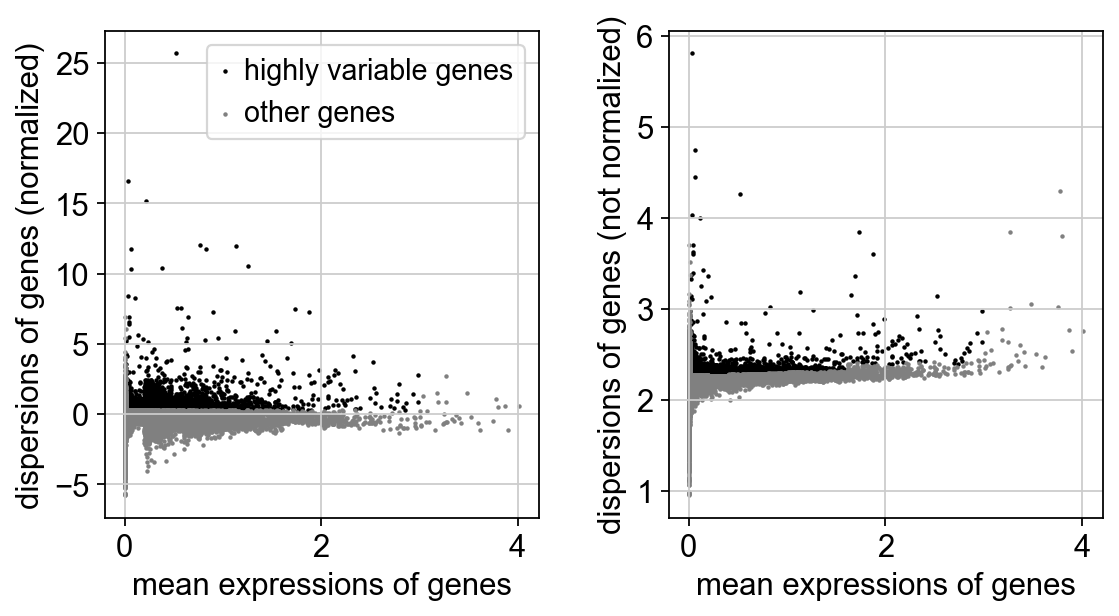

Data has 3754 genes in 15093 cells


In [18]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3.0, min_disp=0.3)

sc.pl.highly_variable_genes(adata)
#filter to only include HVGs

adata = adata[:, adata.var.highly_variable]

print('Data has', adata.n_vars, 'genes in', adata.n_obs, 'cells')

## Dimensionality reduction


Colormap for plotting


In [19]:
cmap = LinearSegmentedColormap.from_list(name='gene_cmap', colors=['lightgrey', 'thistle', 'red', 'darkred'])


### Calculate PCA

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data. 

Scale to unit variance for PCA, and clip values exceeding variance 10.

In [20]:

sc.pp.normalize_per_cell(adata,counts_per_cell_after=1e4)  # need to redo normalization after filtering
sc.pp.log1p(adata)  # log transform: X = log(X + 1)
sc.pp.scale(adata,max_value=10)
sc.tl.pca(adata, svd_solver='arpack')


normalizing by total count per cell


Trying to set attribute `.obs` of view, copying.


    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:11)


Inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or UMAP sc.tl.umap(). Often, a rough estimate of the number of PCs does fine. 

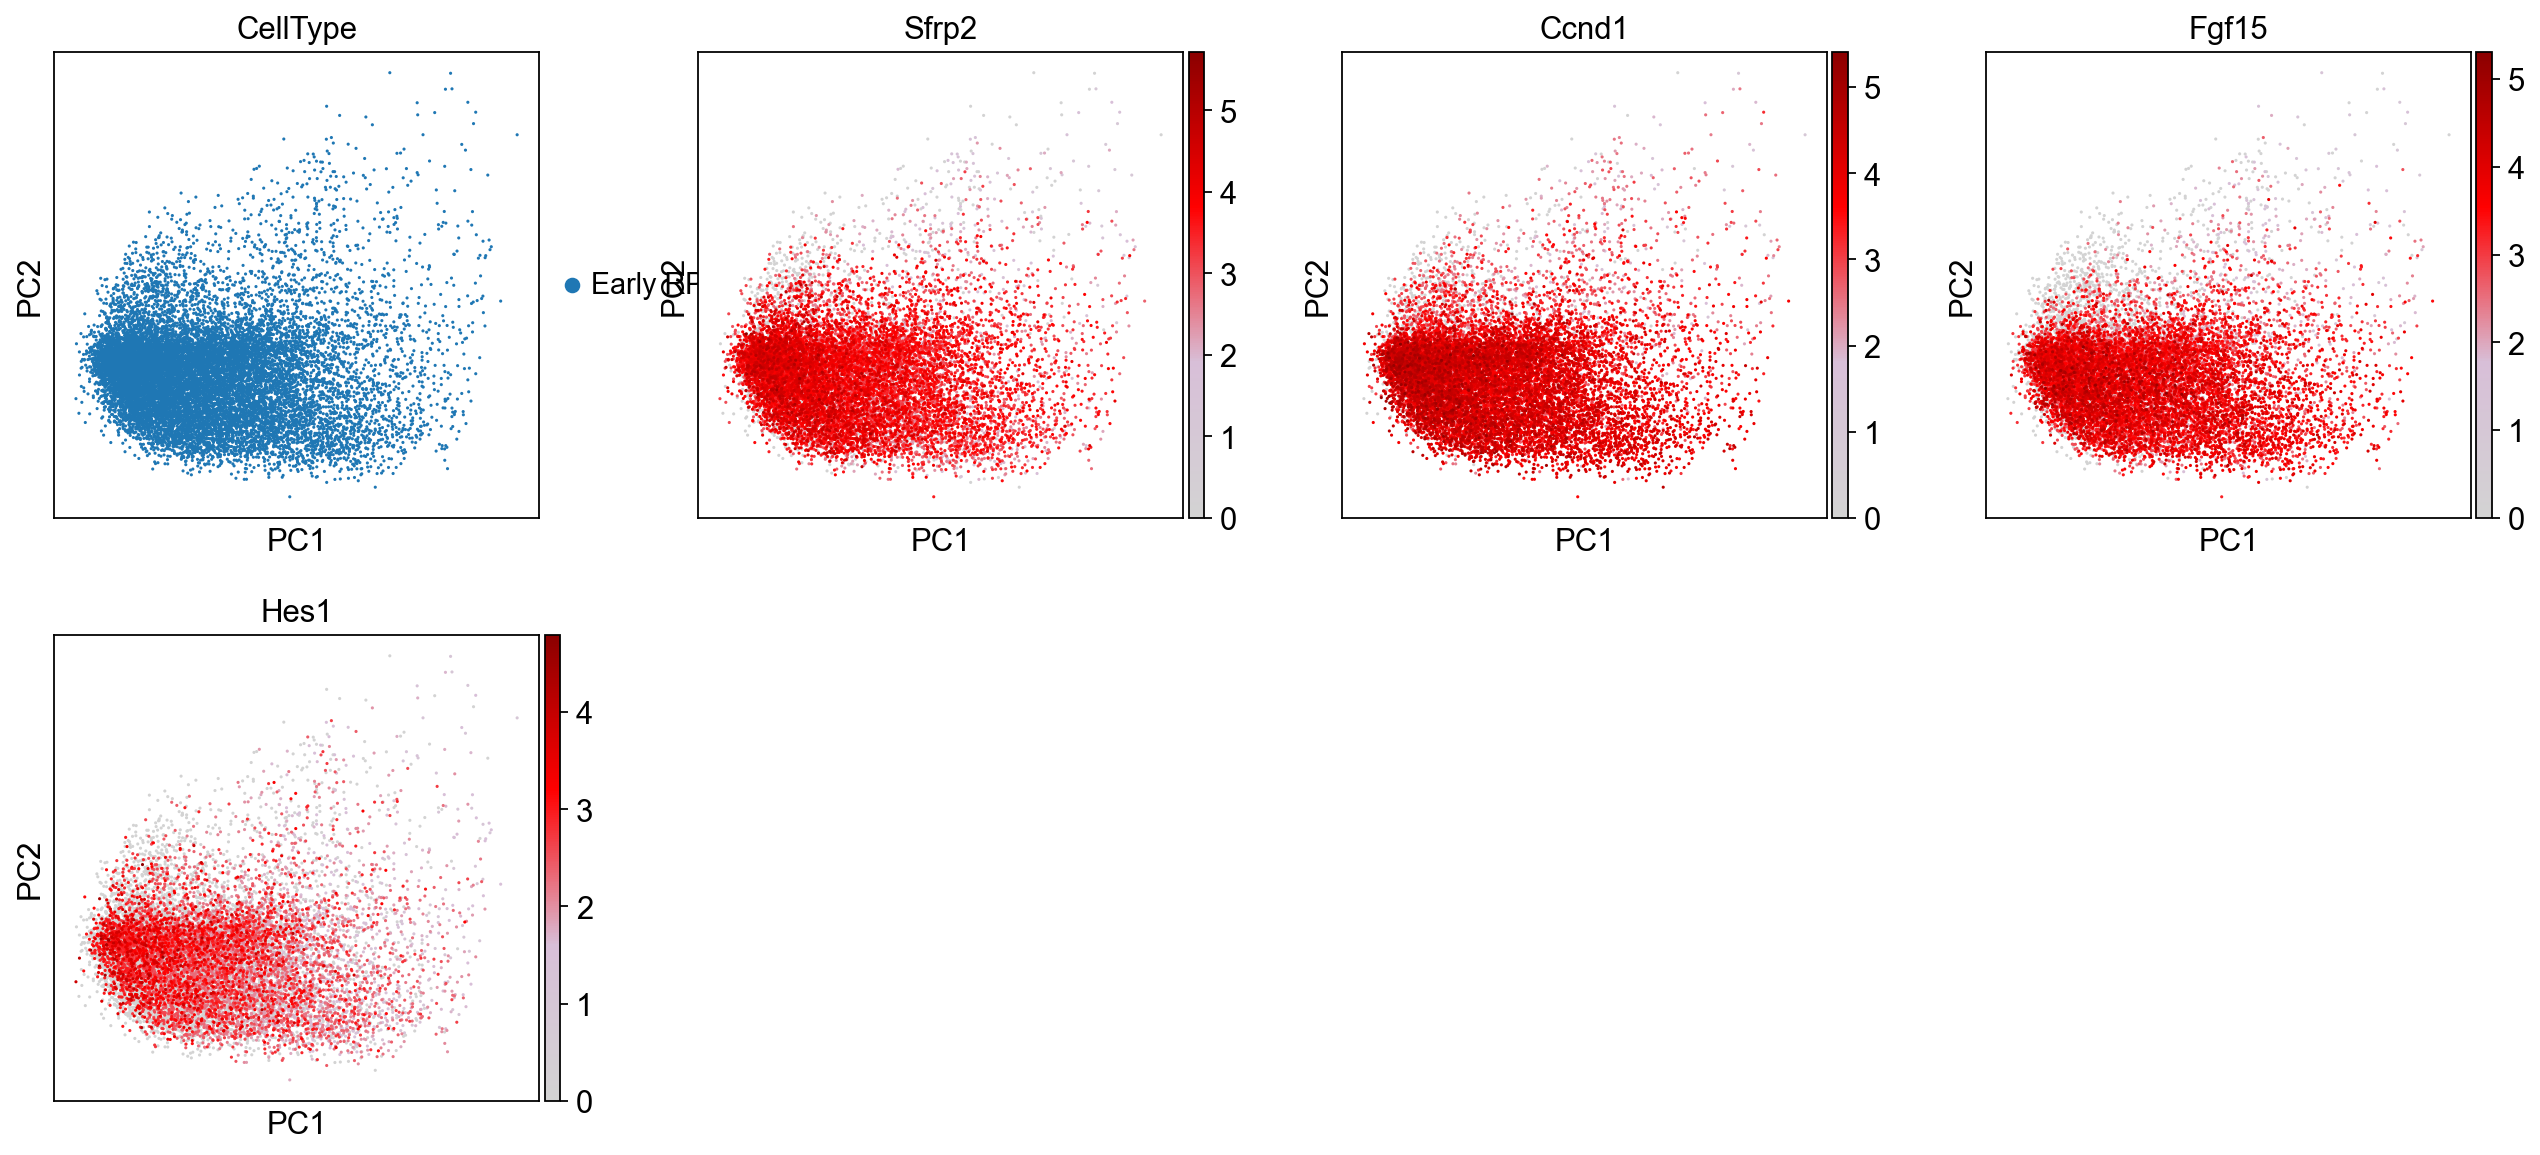

In [21]:
# Plot
sc.pl.pca_scatter(adata, color=['CellType', 'Sfrp2', 'Ccnd1', 'Fgf15', 'Hes1'], color_map=cmap)

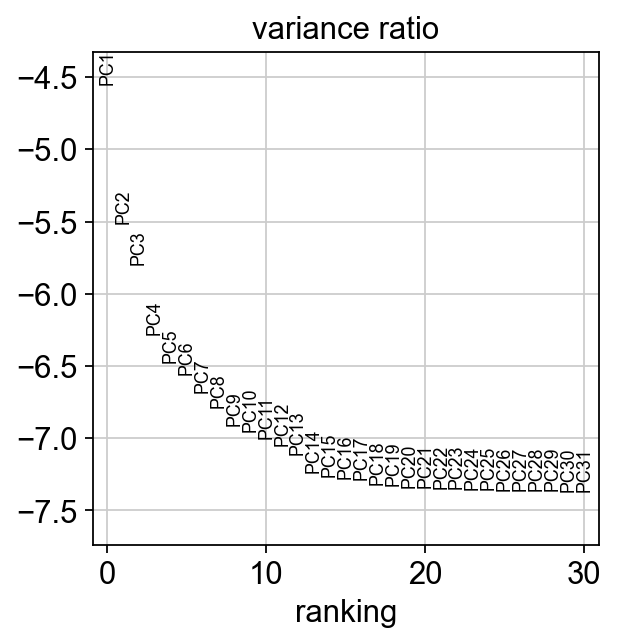

In [22]:
sc.pl.pca_variance_ratio(adata, log=True)


## Compute the neighborhood graph


Next we compute the neighborhood graph of cells using the PCA representation of the data matrix. Number of principal components used here (n_pcs=24).

In [23]:
sc.pp.neighbors(adata, n_neighbors=25, n_pcs=24)


computing neighbors
    using 'X_pca' with n_pcs = 24
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:19)


## Cluster the neighborhood graph 


There are many algorithms for clustering cells, and while they have been compared in detail in various benchmarks. Here we demonstrate clustering using Louvain clustering, which is a popular method for clustering single-cell RNA-seq data. 

Note that Louvain clustering directly clusters the neighborhood graph of cells, which we already computed in the previous section.

In [24]:
sc.tl.louvain(adata, resolution=0.6, random_state=0)


running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished: found 8 clusters and added
    'louvain', the cluster labels (adata.obs, categorical) (0:00:02)


Visualizing data with umap


computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:11)


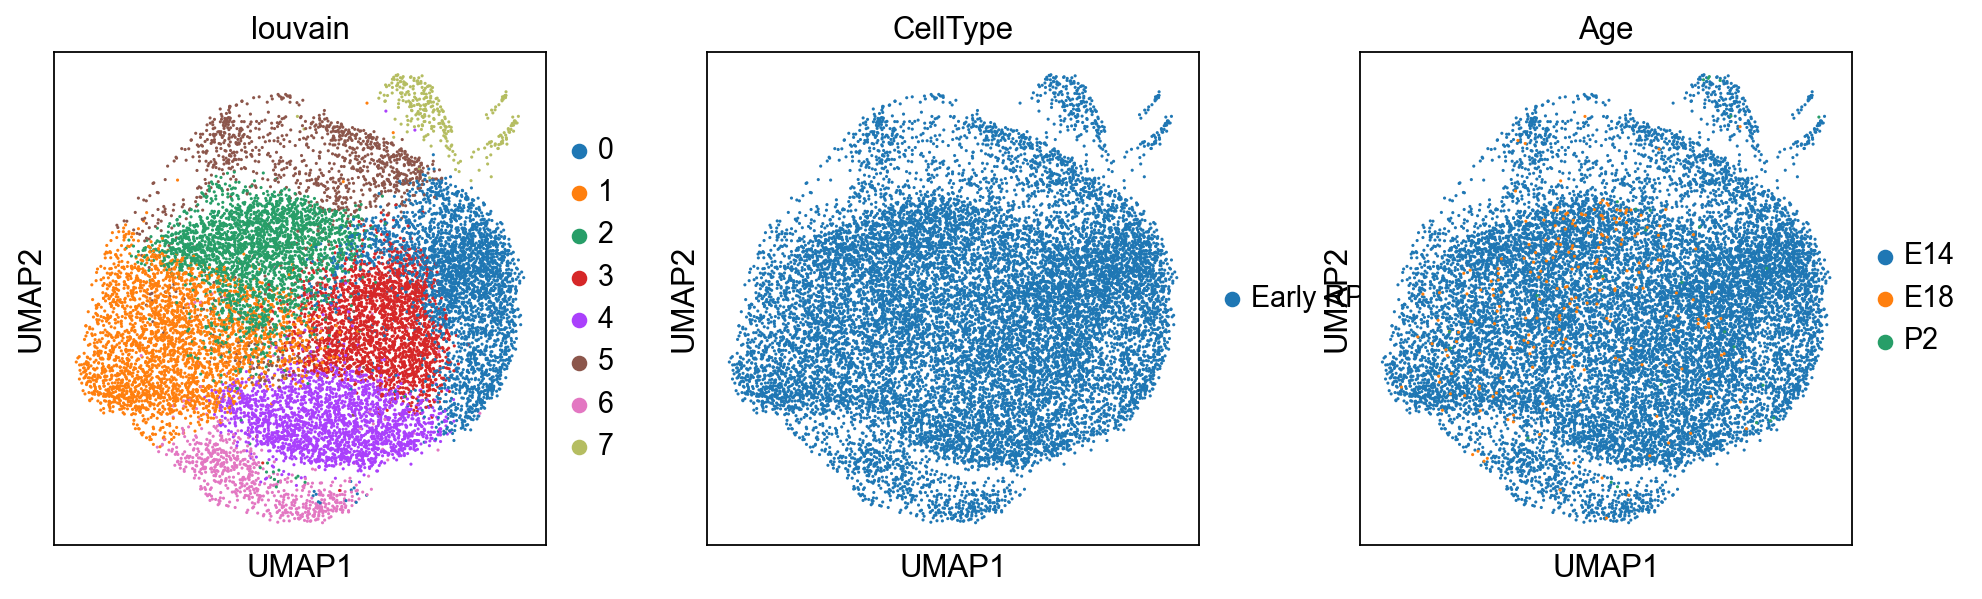

The CellType Rand index is 0.0
The Age Rand index is -0.0


In [25]:
sc.tl.umap(adata, min_dist=0.5, spread=1.0, random_state=1, n_components=2)

sc.pl.umap(adata, color= ['louvain','CellType', 'Age'])

rand_index = adjusted_rand_score(labels_true = adata.obs['CellType'], labels_pred = adata.obs['louvain'])
rand_index_age = adjusted_rand_score(labels_true = adata.obs['Age'], labels_pred = adata.obs['louvain'])
print('The CellType Rand index is', round(rand_index, 2))
print('The Age Rand index is', round(rand_index_age, 2))


Showing similarities between clusters obtained by lovain algotithm and cell types import along with the data

Changing cluster names of louvain clustering scheme based on their similarity with original cell types, 

Showing similarities between clusters obtained by lovain algotithm and age groupss imported along with the data

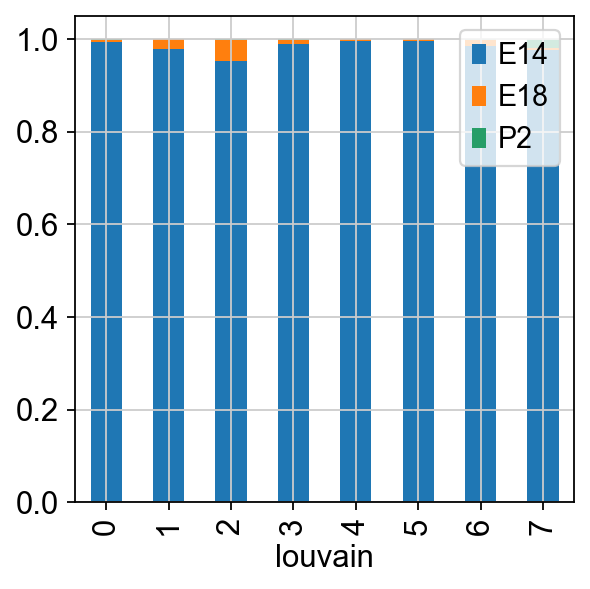

In [26]:
tmp = pd.crosstab(adata.obs['louvain'],adata.obs['Age'], normalize='index')

tmp.plot.bar(stacked=True).legend(loc='upper right')


Compute number of cells in each lovain cluster group, and also in each cell type category

In [27]:
n_genes=25

cluster_distrib = adata.obs.groupby("louvain").count()["n_genes"]
age_distrib = adata.obs.groupby("Age").count()["n_genes"]


for c in cluster_distrib.index:
    print(
        "Cluster %s (%d cells):"
        % (
            c,
            cluster_distrib[c],
        )
    )


Cluster 0 (2954 cells):
Cluster 1 (2833 cells):
Cluster 2 (2564 cells):
Cluster 3 (2394 cells):
Cluster 4 (2172 cells):
Cluster 5 (1169 cells):
Cluster 6 (715 cells):
Cluster 7 (292 cells):


In [28]:

for ct in adata.obs.Age.cat.categories:
    print(
        "Age %s (%d cells):"
        % (
            ct,
            age_distrib[ct],
        )
    )  

Age E14 (14836 cells):
Age E18 (230 cells):
Age P2 (27 cells):


## Calculate diffusion maps

Identifying and removing cell cycle effect
In diffusion map, strange loop shape can imply needing to recompute dimensionality reduction on the dataset with cell cycle genes removed. We don't perform this analysis on our dataset, but it seems it may be necessary. 


computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.96688116 0.9628155  0.9594303  0.9467271  0.9394351
     0.92399746 0.9229127  0.920875   0.914036   0.90383494 0.89379686
     0.8822316  0.8800429  0.8665603 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)


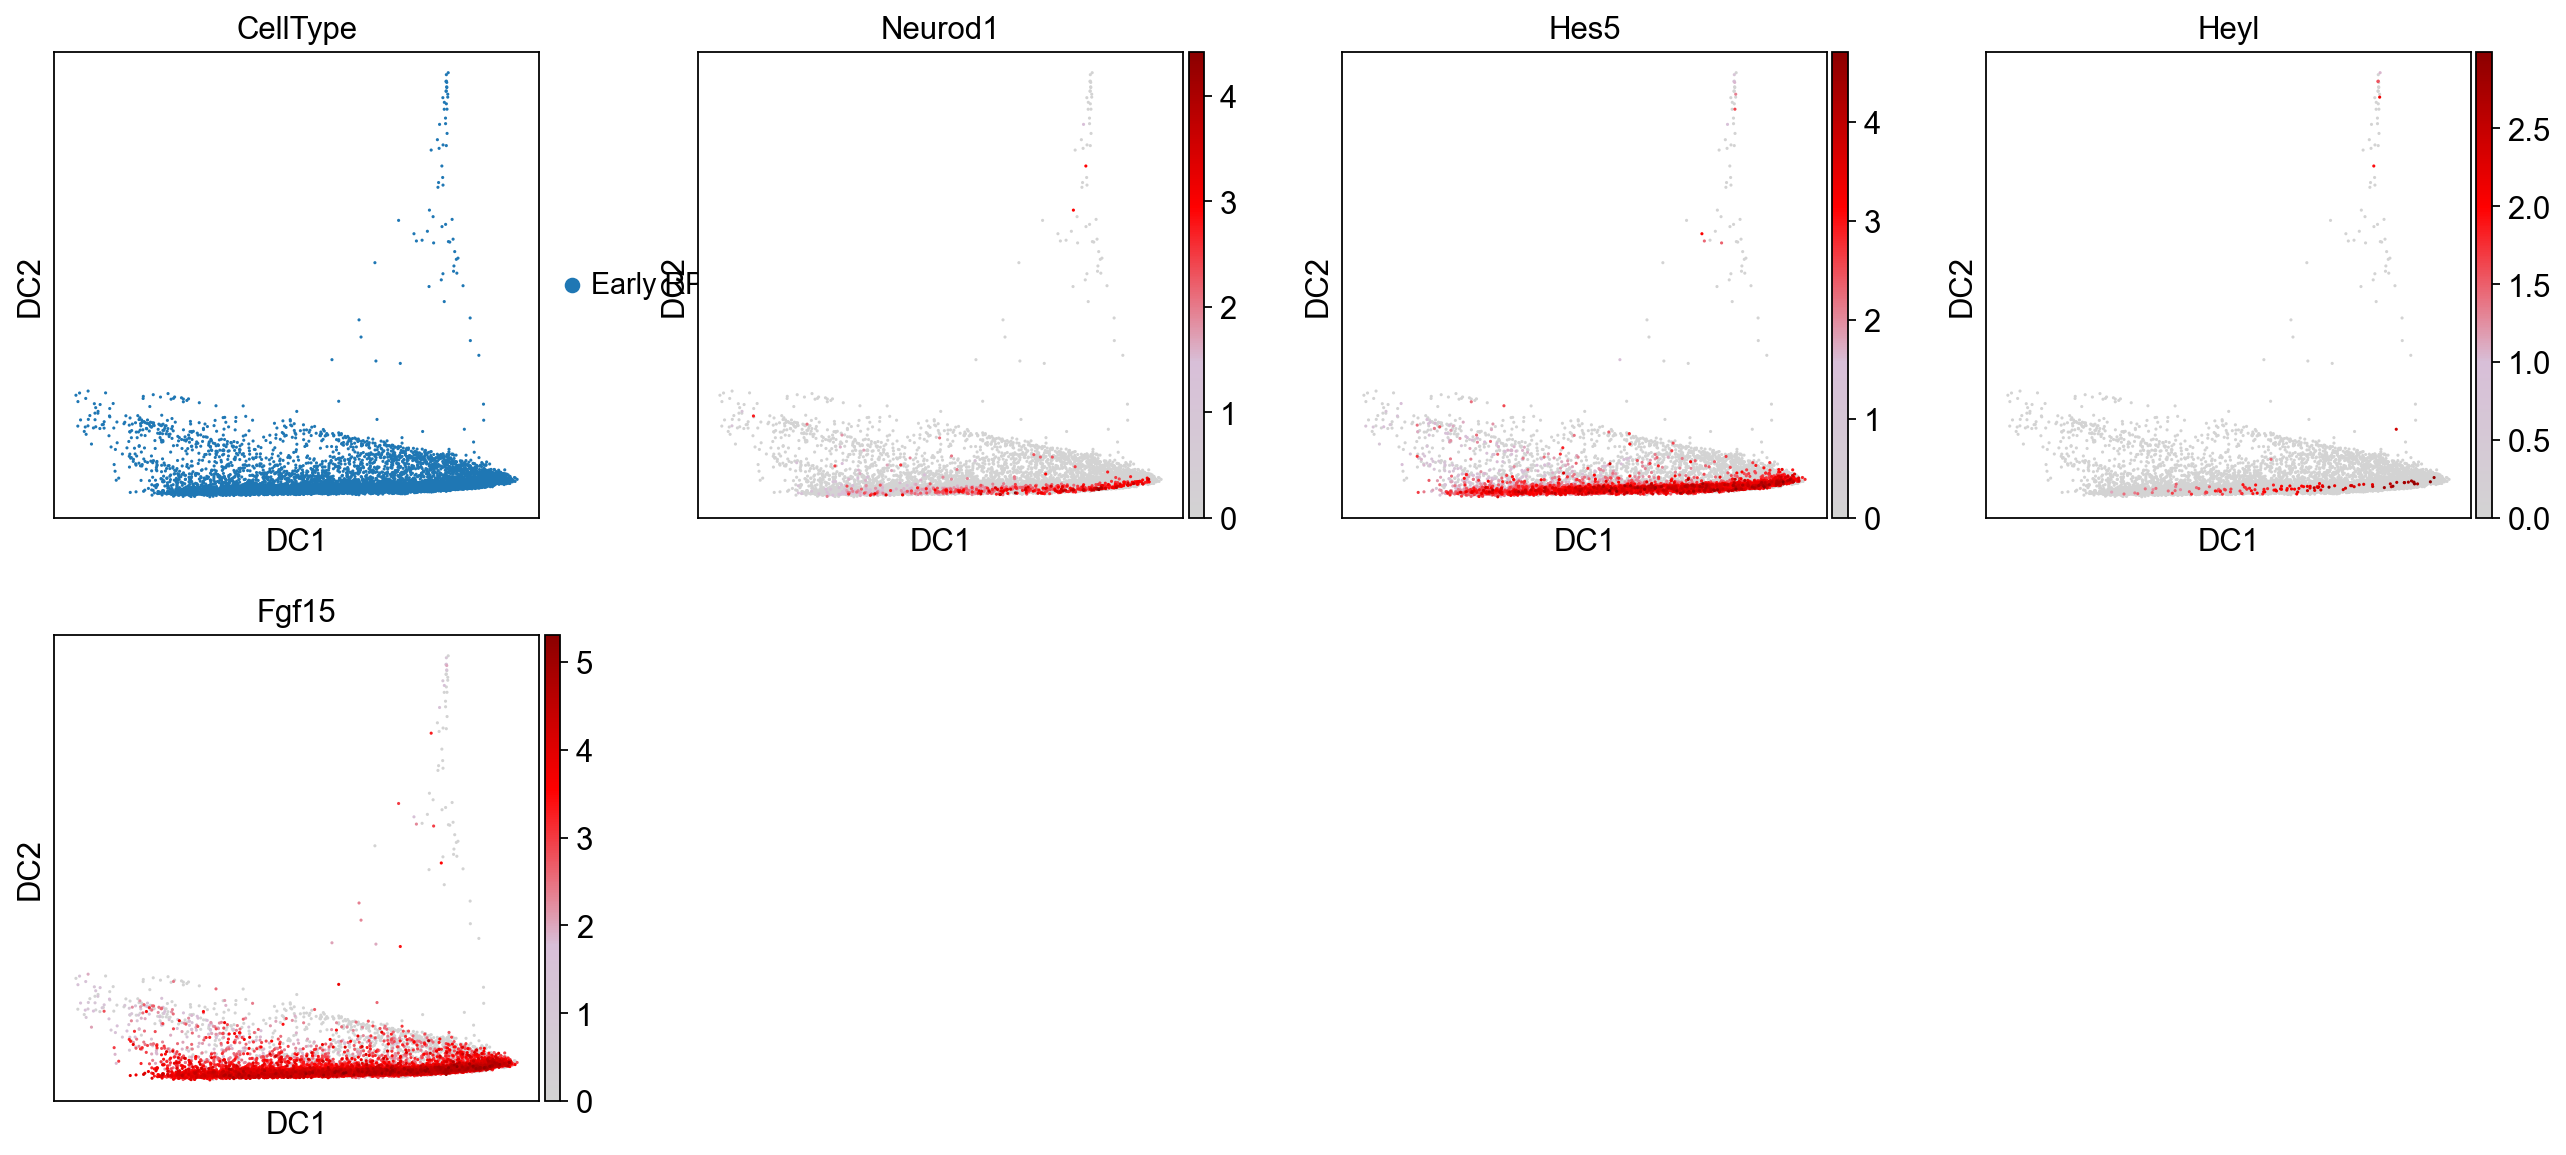

In [29]:
sc.tl.diffmap(adata)

sc.pl.diffmap(adata, color=['CellType', 'Neurod1', 'Hes5', 'Heyl', 'Fgf15'], color_map=cmap)

## find marker genes


A key aspect of annotating a cell atlas is identifying "marker genes". These are genes specific to individual clusters that "mark" them, and are important both for assigning functions to cell clusters, and for designing downstream experiments to probe activity of clusters. Once we have done clustering, let's compute a ranking for the highly differential genes in each cluster.

A gene marker analysis begins with ranking genes in each cluster according to how different they are relative to other clusters. The default method to compute differential expression is the t-test_overestim_var. Other implemented methods are: logreg, t-test and wilcoxon.  Here we compute ranking for differential genes in each cluster using wilcoxon rank-sum. 

By default, the .raw attribute of AnnData is used in case it has been initialized, it can be changed by setting use_raw=False.


method='wilcoxon', group_by='louvain'


ranking genes
    finished: added to `.uns['wilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:15)


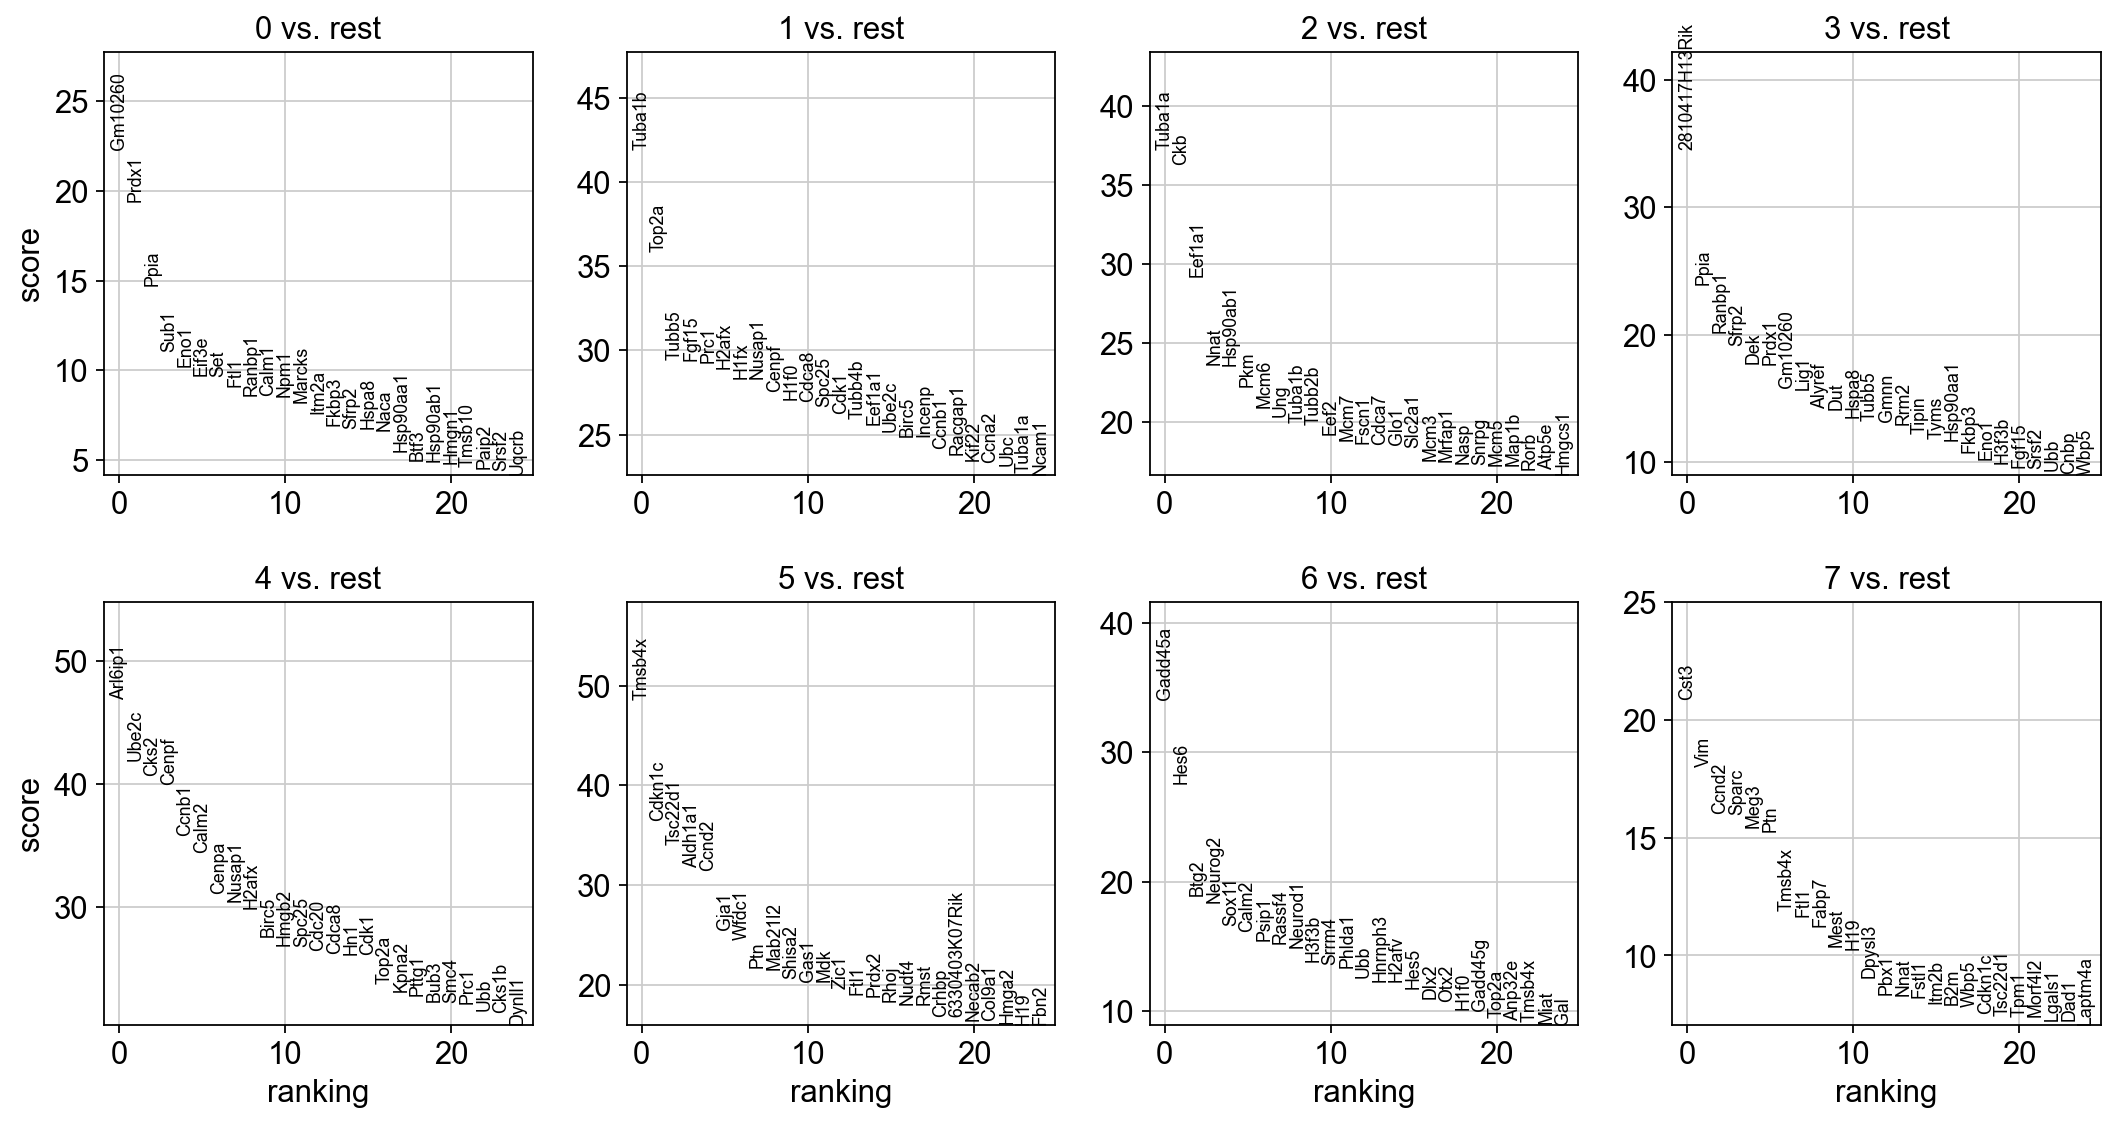

In [30]:
sc.tl.rank_genes_groups(adata, 'louvain' ,n_genes=n_genes, method='wilcoxon', key_added = "wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "wilcoxon")



method='wilcoxon', group_by='CellType'


method='wilcoxon', group_by='Age'


ranking genes
    finished: added to `.uns['wilcoxon_Age']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:14)


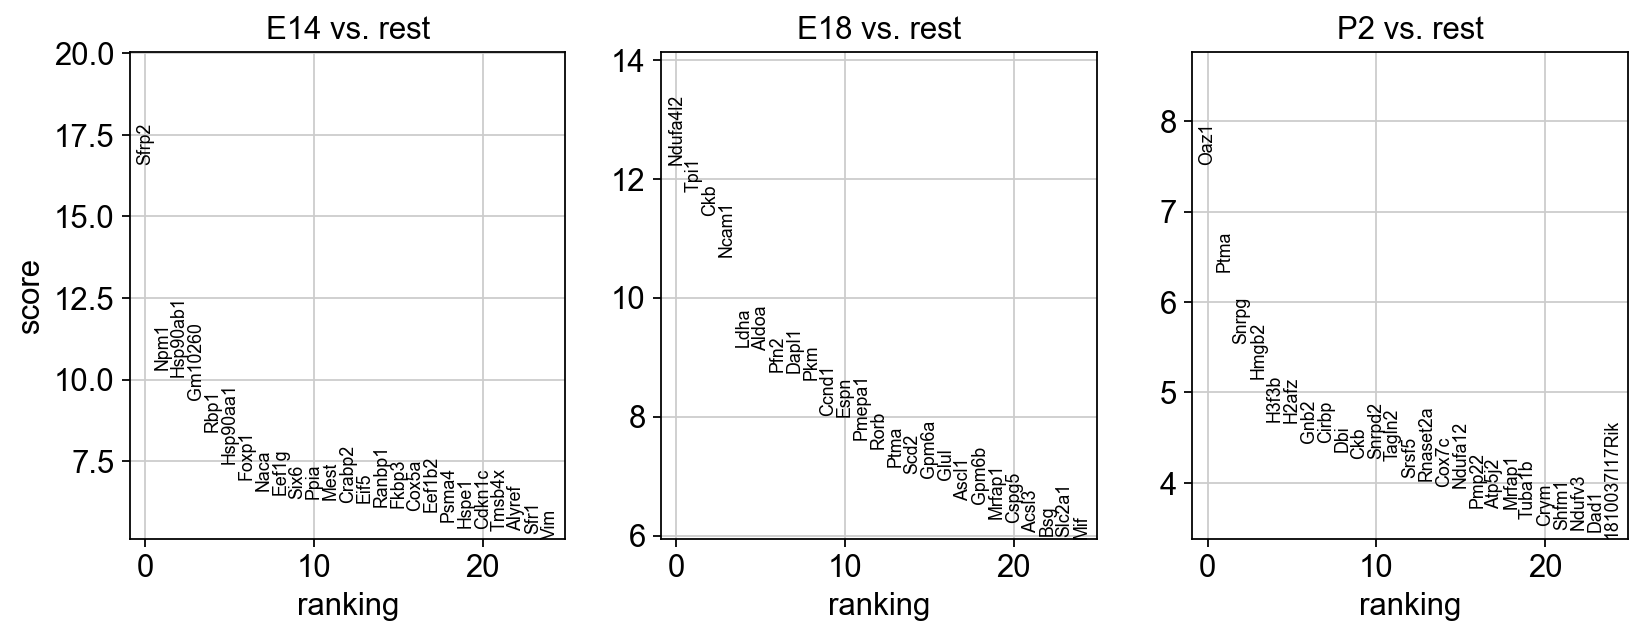

In [31]:

sc.tl.rank_genes_groups(adata, 'Age' ,n_genes=n_genes, method='wilcoxon', key_added = "wilcoxon_Age")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "wilcoxon_Age")

Visualization
There are several ways to visualize the expression of top DE genes. Here we will plot top 5 genes per cluster from Wilcoxon test as heatmap, dotplot, violin plot or matrix.

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_louvain']`


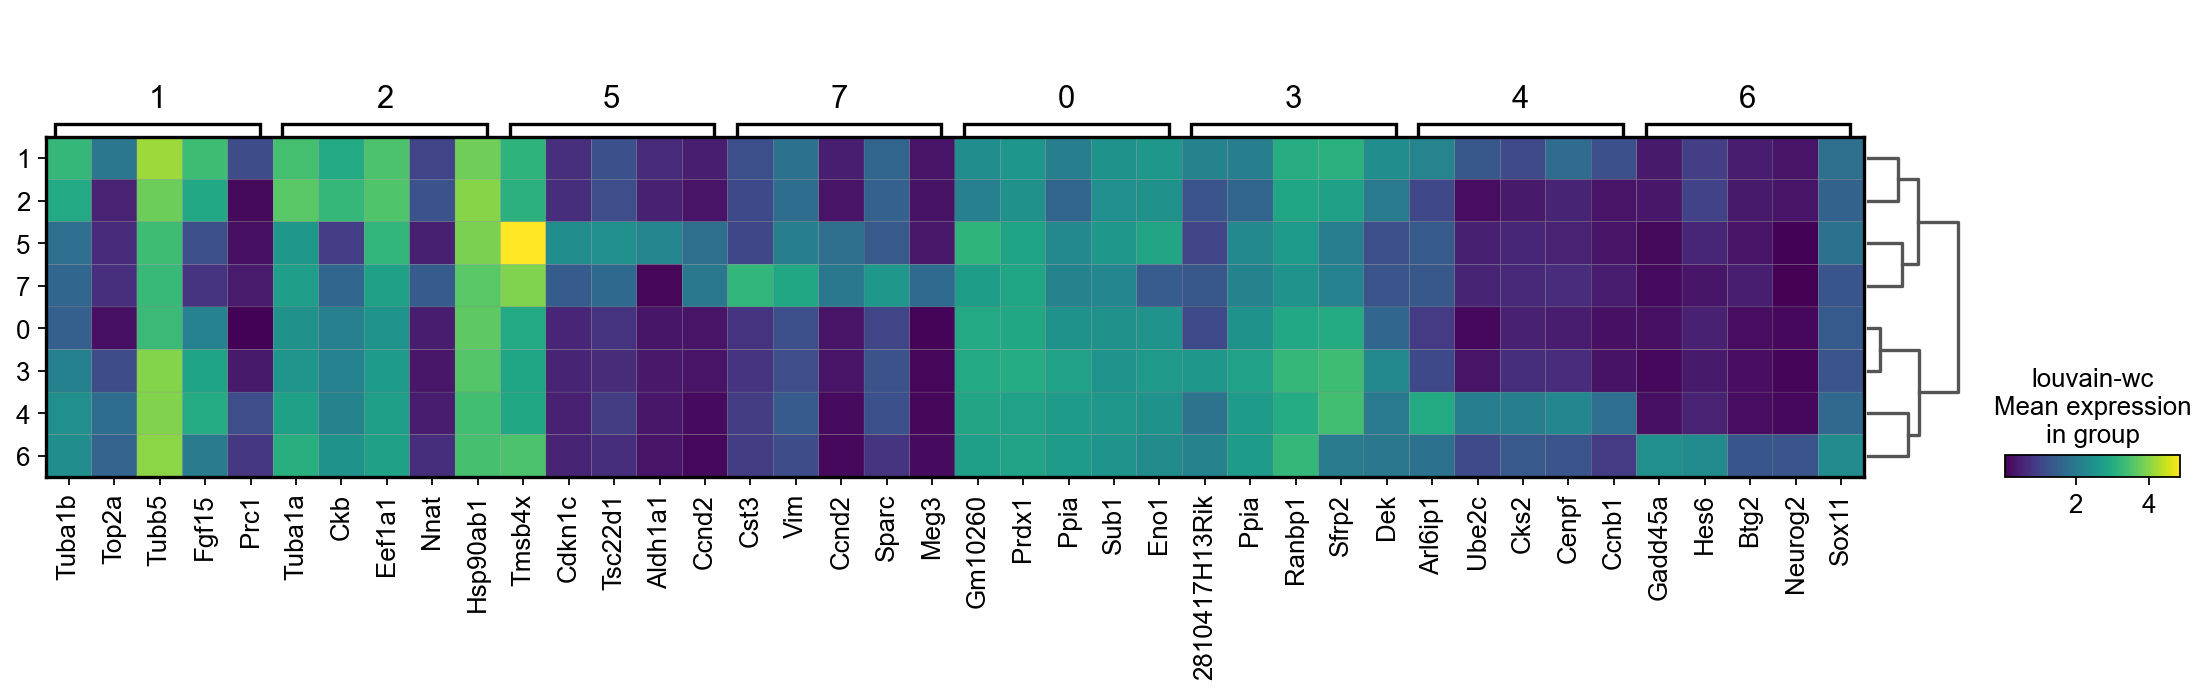

In [32]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, key="wilcoxon", groupby="louvain", colorbar_title ='louvain-wc\nMean expression\nin group')

    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_Age']`


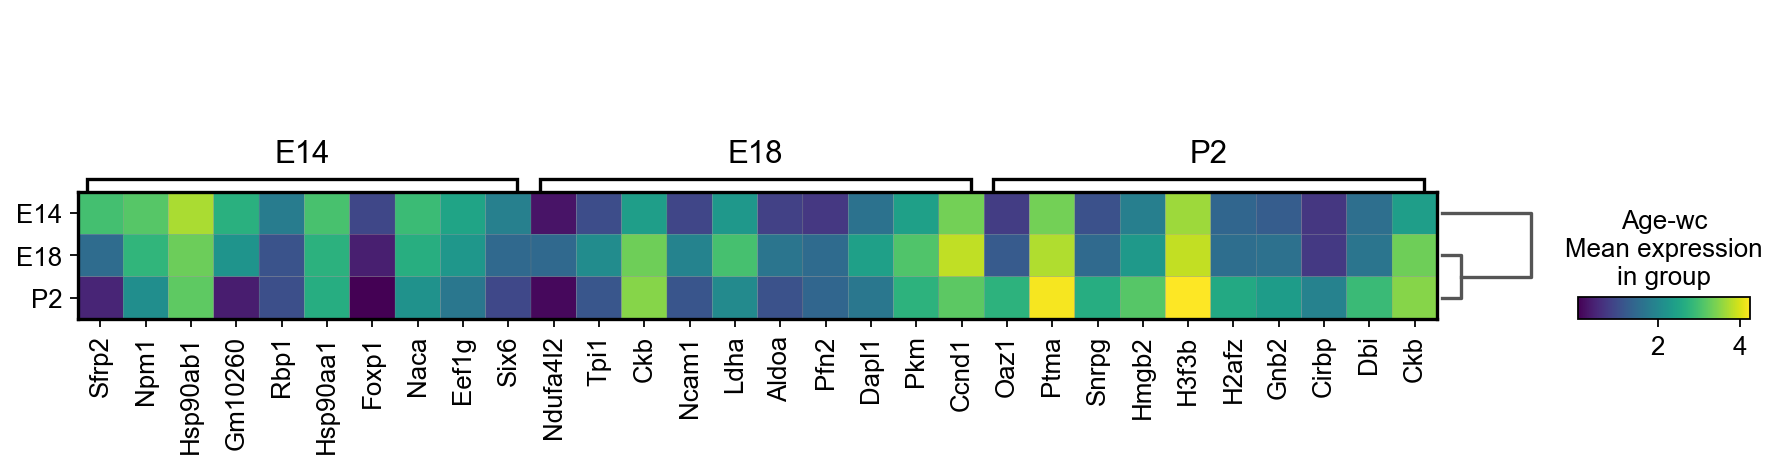

In [33]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=10, key="wilcoxon_Age", groupby="Age", colorbar_title ='Age-wc\nMean expression\nin group')

Show the 5 top ranked genes per cluster in a dataframe.

In [34]:
pd.DataFrame(adata.uns['wilcoxon']['names']).head(5)


0       1         2              3        4        5        6      7
0  Gm10260  Tuba1b    Tuba1a  2810417H13Rik  Arl6ip1   Tmsb4x  Gadd45a   Cst3
1    Prdx1   Top2a       Ckb           Ppia    Ube2c   Cdkn1c     Hes6    Vim
2     Ppia   Tubb5    Eef1a1         Ranbp1     Cks2  Tsc22d1     Btg2  Ccnd2
3     Sub1   Fgf15      Nnat          Sfrp2    Cenpf  Aldh1a1  Neurog2  Sparc
4     Eno1    Prc1  Hsp90ab1            Dek    Ccnb1    Ccnd2    Sox11   Meg3

In [35]:
pd.DataFrame(adata.uns['wilcoxon_Age']['names']).head(10)  

E14       E18     P2
0     Sfrp2  Ndufa4l2   Oaz1
1      Npm1      Tpi1   Ptma
2  Hsp90ab1       Ckb  Snrpg
3   Gm10260     Ncam1  Hmgb2
4      Rbp1      Ldha  H3f3b
5  Hsp90aa1     Aldoa  H2afz
6     Foxp1      Pfn2   Gnb2
7      Naca     Dapl1  Cirbp
8     Eef1g       Pkm    Dbi
9      Six6     Ccnd1    Ckb

Marker genes without using raw data


ranking genes
    finished: added to `.uns['rfwilcoxon']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


C:\ProgramData\Anaconda3\envs\retisep\lib\site-packages\scanpy\tools\_rank_genes_groups.py:421: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


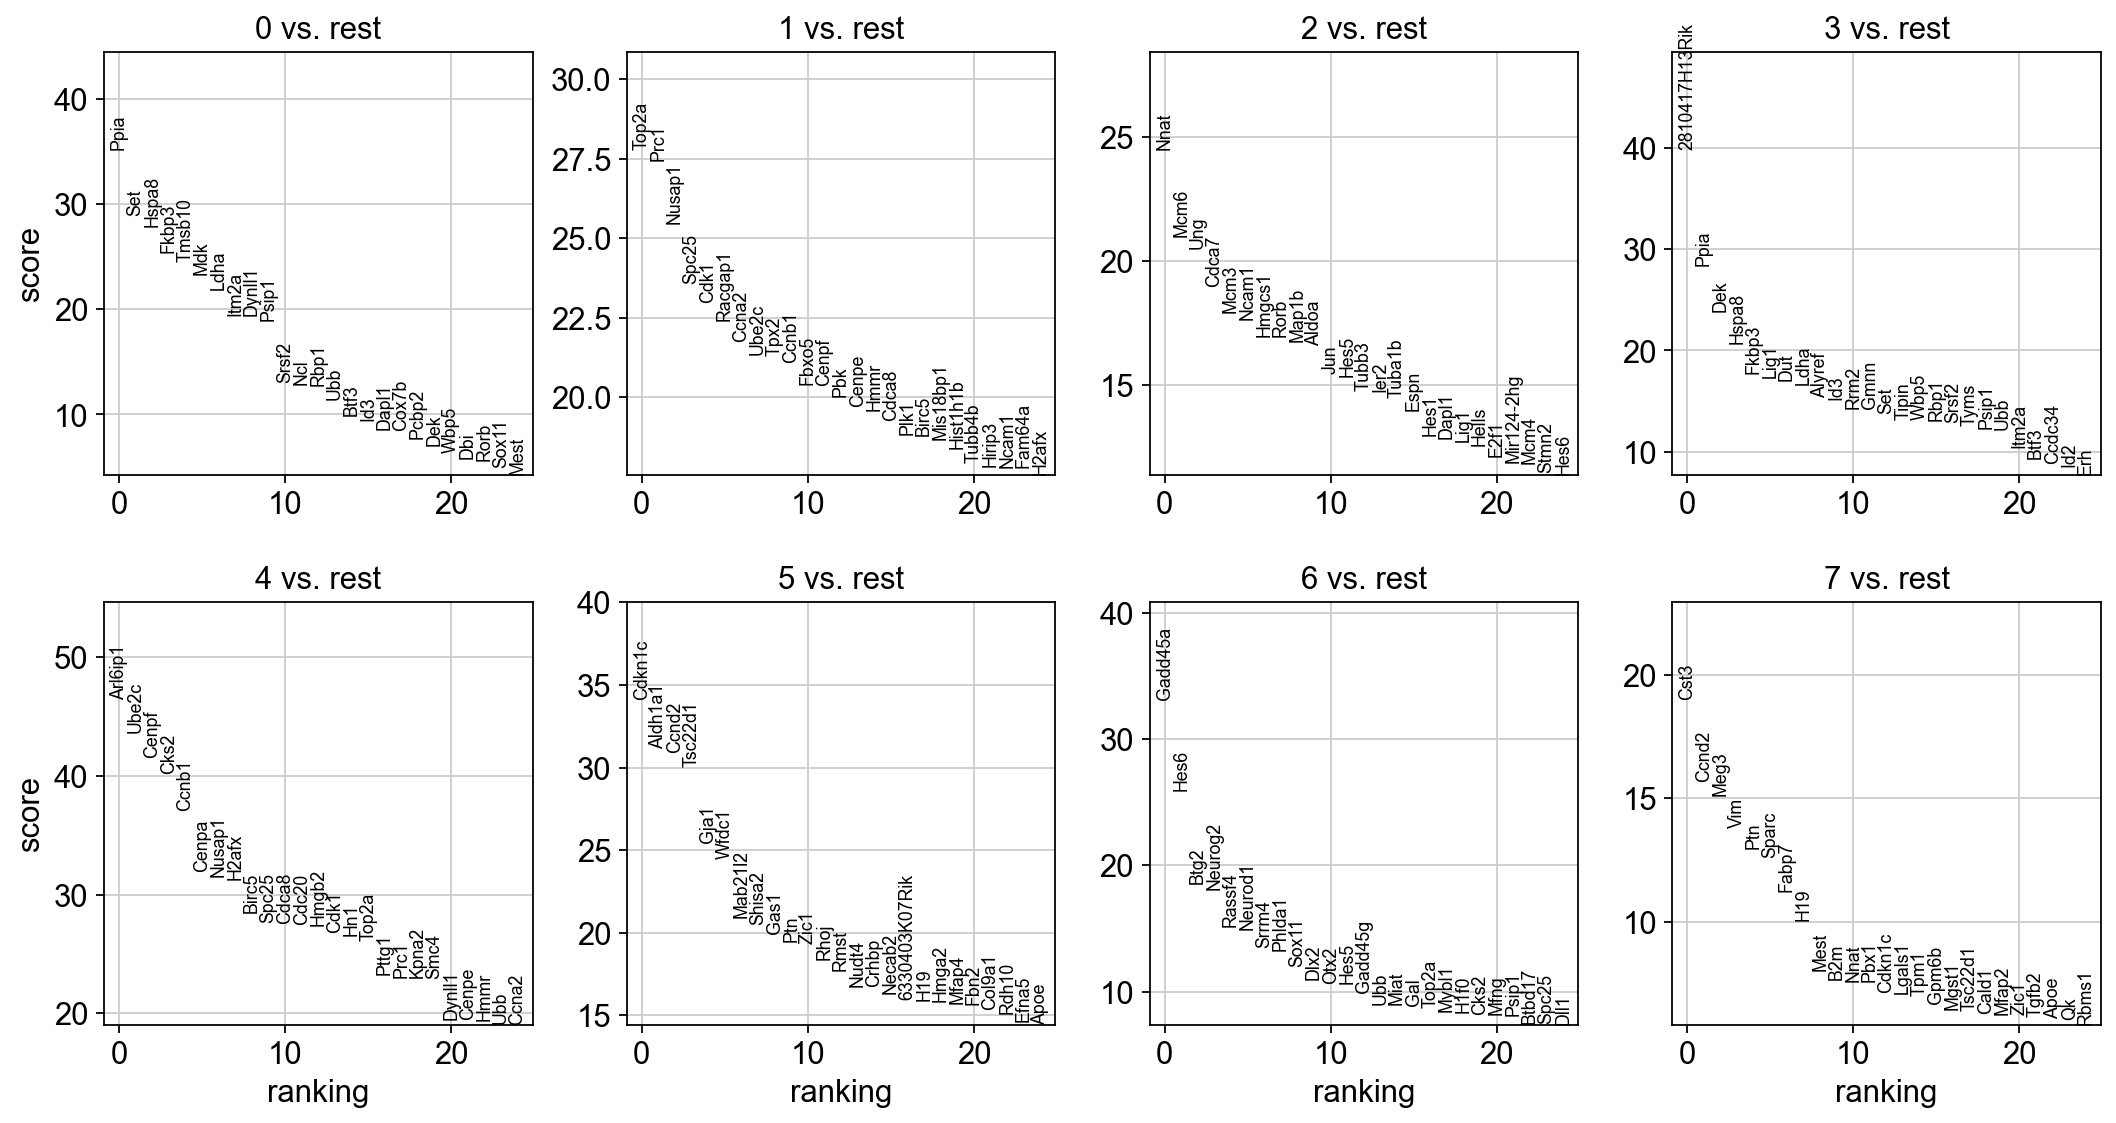

In [36]:
sc.tl.rank_genes_groups(adata, 'louvain' ,n_genes=n_genes, method='wilcoxon',use_raw=False, key_added = "rfwilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "rfwilcoxon")     


ranking genes
    finished: added to `.uns['rfwilcoxon_Age']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:03)


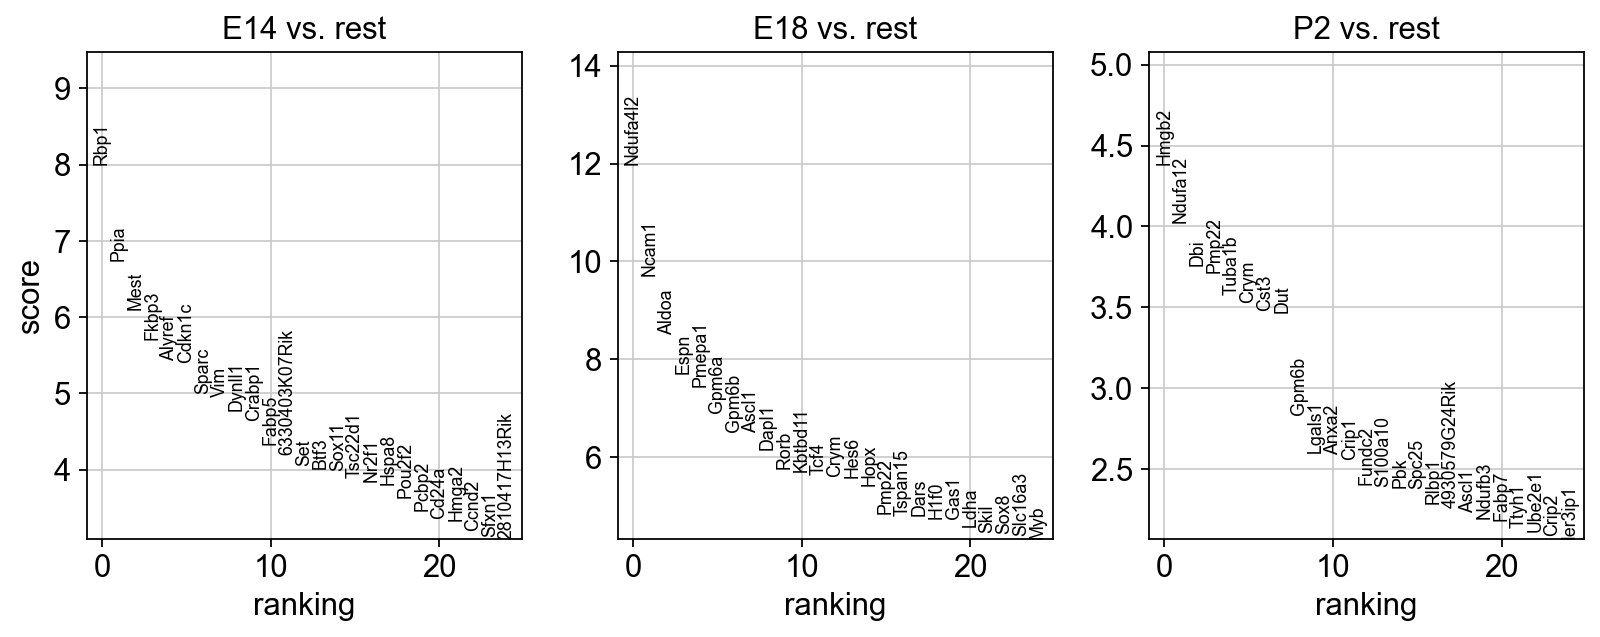

In [37]:
sc.tl.rank_genes_groups(adata, 'Age' ,n_genes=n_genes, method='wilcoxon',use_raw=False, key_added = "rfwilcoxon_Age")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False, key = "rfwilcoxon_Age")  


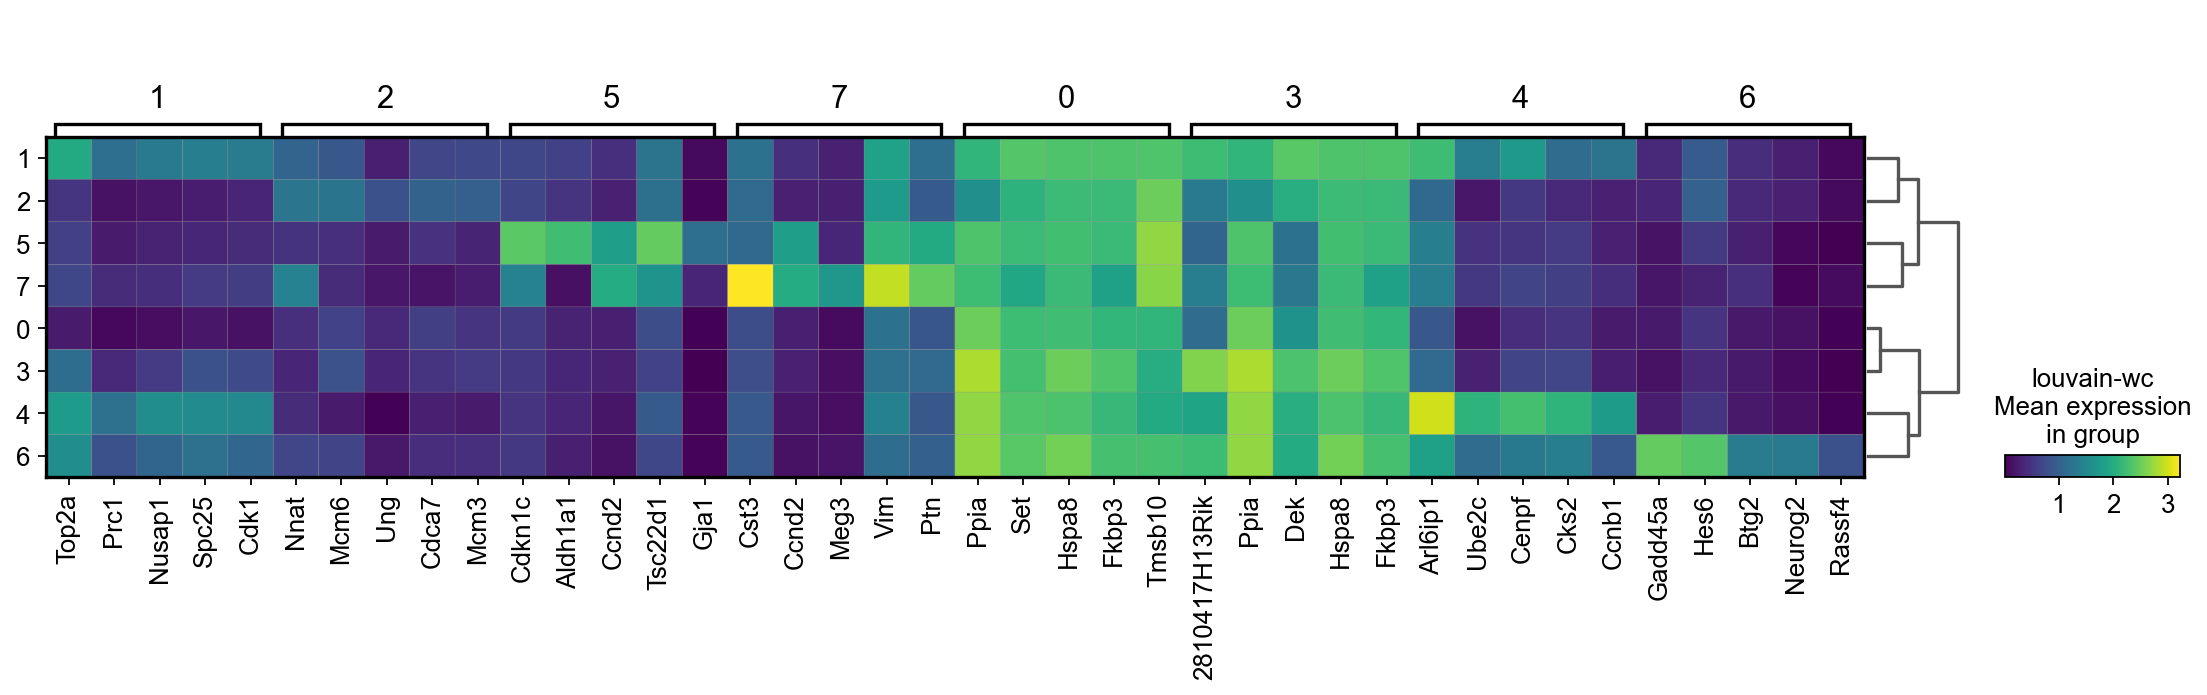

In [38]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=5, key="rfwilcoxon", groupby="louvain", colorbar_title ='louvain-wc\nMean expression\nin group')

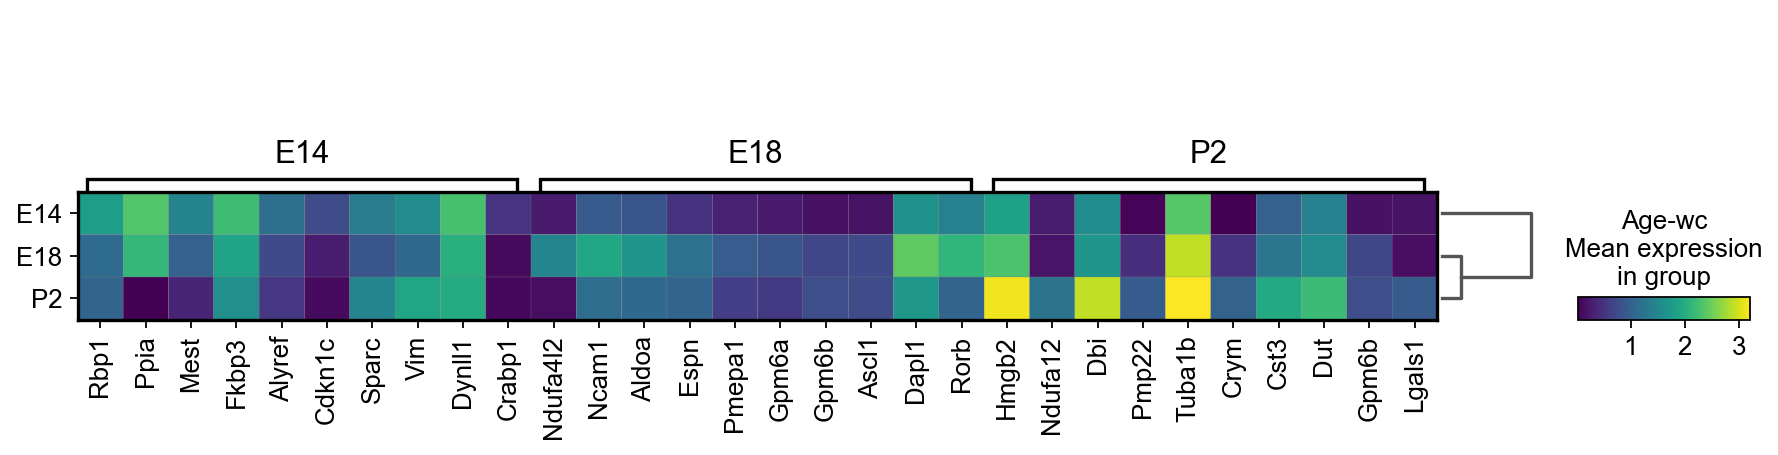

In [39]:
sc.pl.rank_genes_groups_matrixplot(adata, n_genes=10, key="rfwilcoxon_Age", groupby="Age", colorbar_title ='Age-wc\nMean expression\nin group')

In [40]:
pd.DataFrame(adata.uns['rfwilcoxon']['names']).head(10)


0        1       2              3        4        5        6      7
0    Ppia    Top2a    Nnat  2810417H13Rik  Arl6ip1   Cdkn1c  Gadd45a   Cst3
1     Set     Prc1    Mcm6           Ppia    Ube2c  Aldh1a1     Hes6  Ccnd2
2   Hspa8   Nusap1     Ung            Dek    Cenpf    Ccnd2     Btg2   Meg3
3   Fkbp3    Spc25   Cdca7          Hspa8     Cks2  Tsc22d1  Neurog2    Vim
4  Tmsb10     Cdk1    Mcm3          Fkbp3    Ccnb1     Gja1   Rassf4    Ptn
5     Mdk  Racgap1   Ncam1           Lig1    Cenpa    Wfdc1  Neurod1  Sparc
6    Ldha    Ccna2  Hmgcs1            Dut   Nusap1  Mab21l2    Srrm4  Fabp7
7   Itm2a    Ube2c    Rorb           Ldha    H2afx   Shisa2   Phlda1    H19
8  Dynll1     Tpx2   Map1b         Alyref    Birc5     Gas1    Sox11   Mest
9   Psip1    Ccnb1   Aldoa            Id3    Spc25      Ptn     Dlx2    B2m

In [41]:
pd.DataFrame(adata.uns['rfwilcoxon_Age']['names']).head(10)

E14       E18       P2
0    Rbp1  Ndufa4l2    Hmgb2
1    Ppia     Ncam1  Ndufa12
2    Mest     Aldoa      Dbi
3   Fkbp3      Espn    Pmp22
4  Alyref    Pmepa1   Tuba1b
5  Cdkn1c     Gpm6a     Crym
6   Sparc     Gpm6b     Cst3
7     Vim     Ascl1      Dut
8  Dynll1     Dapl1    Gpm6b
9  Crabp1      Rorb   Lgals1